# Binary classification with a basic neural network

We will setup a two layers linear network with one hyperbolic tangent module between these layers, and one sigmoid module after the last hidden layer of the network.

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from pyldl.activations import Sigmoid, Tanh, Softmax, ReLU
from pyldl.losses import MSELoss
from pyldl.modules import Linear
from pyldl.utils import gen_arti, plot_data, plot_frontiere

In [3]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

## Sigmoid and Tanh Activation Functions

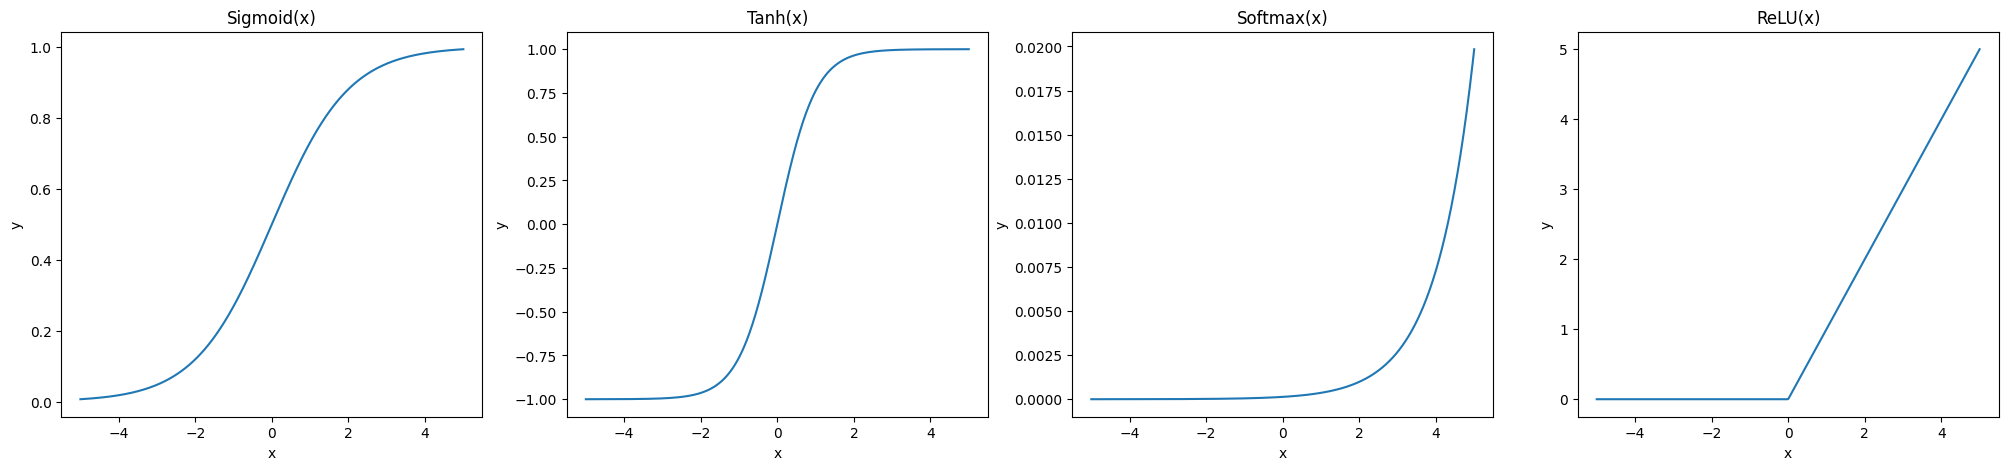

In [27]:
X = np.linspace(-5, 5, 500)

def plot_activation(activation, data):
    plt.plot(data, activation(data))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{activation.__class__.__name__}(x)")

activations = [Sigmoid(), Tanh(), Softmax(), ReLU()]
plt.subplots(1, 4, figsize=(25, 5))
for i, activation in enumerate(activations):
    plt.subplot(1, 4, i+1)
    plot_activation(activation, X)
plt.show()

In [16]:
X = np.array([0.5, -0.3, 0.8, 5, 1000])
delta_out = np.array([0.2, -0.1, 0.3, 3, 5])

In [17]:
tanh_activation = Tanh()
tanh_output = tanh_activation.forward(X)
tanh_delta = tanh_activation.backward_delta(X, delta_out)

print("Tanh forward output:", tanh_output)
print("Tanh backward delta:", tanh_delta)

Tanh forward output: [ 0.46211716 -0.29131261  0.66403677  0.9999092   1.        ]
Tanh backward delta: [ 0.15728955 -0.0915137   0.16771655  0.00054475  0.        ]


In [19]:
sigmoid_activation = Sigmoid()
sigmoid_output = sigmoid_activation.forward(X)
sigmoid_delta = sigmoid_activation.backward_delta(X, delta_out)

print("Sigmoid forward output:", sigmoid_output)
print("Sigmoid backward delta:", sigmoid_delta)

Sigmoid forward output: [0.62245933 0.42555748 0.68997448 0.99330715 1.        ]
Sigmoid backward delta: [ 0.04700074 -0.02444583  0.06417291  0.01994417  0.        ]


## Dataset and Network

In [7]:
np.random.seed(0)

In [8]:
X, y = gen_arti(sigma=0.1, nbex=5000, data_type=1, epsilon=0.02)
y = np.where(y == -1, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
network = [Linear(X_train.shape[1], 8), Tanh(), Linear(8, 1), Sigmoid()]
loss = MSELoss()

## Gradient Descent

In [10]:
def gradient_descent(X, y, n_iter_max=1000, gradient_step=1e-3):
    losses = []
    for _ in tqdm(range(n_iter_max)):
        z1 = network[0](X)
        a1 = network[1](z1)
        z2 = network[2](a1)
        a2 = network[3](z2)

        loss_value = loss.forward(y, a2)
        losses.append(loss_value.mean())

        delta_loss = loss.backward(y, a2)
        delta_sig = network[3].backward_delta(z2, delta_loss)
        delta_lin2 = network[2].backward_delta(a1, delta_sig)
        delta_tan = network[1].backward_delta(z1, delta_lin2)

        network[2].backward_update_gradient(a1, delta_sig)
        network[0].backward_update_gradient(X, delta_tan)

        network[2].update_parameters(gradient_step)
        network[0].update_parameters(gradient_step)

        network[2].zero_grad()
        network[0].zero_grad()
    return losses

100%|██████████| 1000/1000 [00:00<00:00, 1175.27it/s]


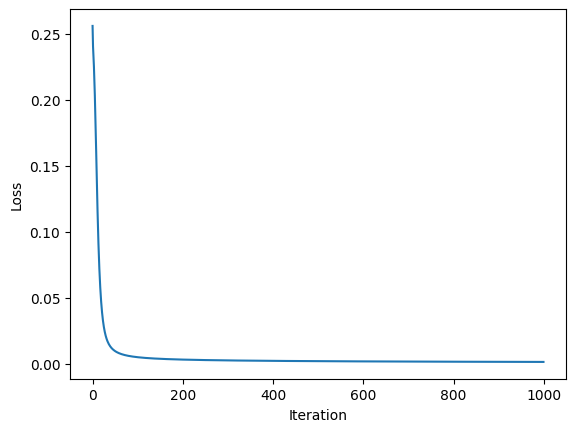

In [11]:
losses = gradient_descent(X_train, y_train)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [12]:
def predict(X):
    z1 = network[0].forward(X)
    a1 = network[1].forward(z1)
    z2 = network[2].forward(a1)
    a2 = network[3].forward(z2)
    return np.where(a2 > 0.5, 1, 0)

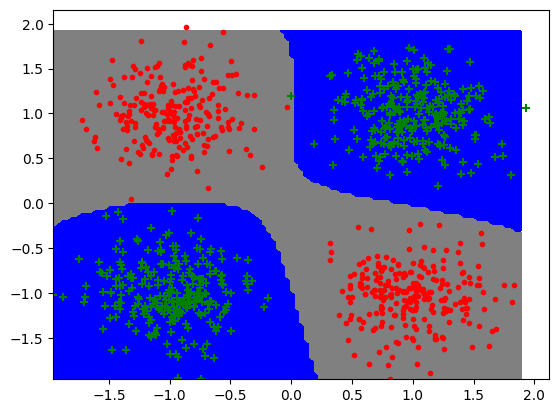

In [13]:
plot_frontiere(X_test, predict, step=100)
plot_data(X_test, y_test)

In [14]:
def accuracy_score(y, yhat):
    return np.mean(y == yhat)

print(f"Accuracy: {accuracy_score(y_test, predict(X_test))*100:.2f}%")

Accuracy: 99.90%
